In [51]:
#import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Import models
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.datasets import make_classification
from sklearn.feature_selection import SelectKBest,f_classif, chi2
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot
from collections import Counter
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso

# metrics evaluation
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import cohen_kappa_score
import statsmodels.api as sm

# To standardise data
from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder
#from imblearn.under_sampling import RandomUnderSampler

# For train/test split
from sklearn.model_selection import train_test_split


from sklearn.feature_selection import VarianceThreshold as vt
#from imblearn.pipeline import make_pipeline, Pipeline
#from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV

In [52]:
#import CSVs, assign headers and remove quotations from column headers
white_wine = pd.read_csv(r'C:\Users\Killian\Projects\Wine analysis\Wine data\winequality-white.csv', sep=';',header=0, engine='python')

In [53]:
white_wine['label'] = white_wine['quality'].apply(lambda value: 'low'
if value <= 4 else 'medium-low'
if value == 5 else 'medium' if value == 6 else 'medium-high' if value == 7 else 'high')

In [54]:
wine = []
for column in white_wine.columns[0:-2]:
        wine.append([white_wine[column].astype(float).skew().round(2), white_wine[column].astype(float).kurt().round(2)])

wine_stats = pd.DataFrame(wine, index=[white_wine.columns[0:-2]], columns=['Skewness', 'Kurtosis'])
display(wine_stats)

,Skewness,Kurtosis
fixed acidity,0.65,2.17
volatile acidity,1.58,5.09
citric acid,1.28,6.17
residual sugar,1.08,3.47
chlorides,5.02,37.56
free sulfur dioxide,1.41,11.47
total sulfur dioxide,0.39,0.57
density,0.98,9.79
pH,0.46,0.53
sulphates,0.98,1.59


In [55]:

white_wine["label"].value_counts()

medium         2198
medium-low     1457
medium-high     880
low             183
high            180
Name: label, dtype: int64

In [56]:
white_wine['label'] = white_wine['quality'].apply(lambda value: 'low' if value <= 5 else 'medium' if value <=6 else 'high')
white_wine.head()
white_wine["label"].value_counts()

medium    2198
low       1640
high      1060
Name: label, dtype: int64

In [57]:
features=white_wine.columns
features

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality', 'label'],
      dtype='object')

In [58]:
white_label = LabelEncoder()
white_wine['category'] = white_label.fit_transform(white_wine['label'])
white_wine['category'].value_counts()
#As seen from previous results, Medium = 2, Low = 1, High = 0.
#Can't use OrdinalEncoder as it is 1D data. Ordinal Encoder is used on 2D array. 

2    2198
1    1640
0    1060
Name: category, dtype: int64

In [59]:
#white_label = OrdinalEncoder(categories=[['low', 'medium', 'high']])
#white_wine['label'].values.reshape(-1,1)
#white_wine['category'] = white_label.fit_transform(white_wine['label'])
#white_wine['category'].value_counts()

In [82]:
white_wine.tail()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,label,category
4893,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6,medium,2
4894,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5,low,1
4895,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6,medium,2
4896,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7,high,0
4897,6.0,0.21,0.38,0.8,0.020,22.0,98.0,0.98941,3.26,0.32,11.8,6,medium,2


In [84]:
#Create target and features for algorithm
#Full feature list for ease of access while doing Backward Eliination and refining model: 'fixed acidity', 'volatile acidity', 'residual sugar', 'density', 'pH', 
# 'sulphates','citric acid', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'alcohol'
X = white_wine.copy()
y = X.category #target
X =white_wine.drop(columns=['quality', 'category', 'label']) # features we want to test, except target and correlated values, i.e. Quality and Label. 
# Final list will include features removed due to results from Backward Elimination.
X_list = list(X.columns)
print(X.columns.tolist())
print(y)

['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']
0       2
1       2
2       2
3       2
4       2
       ..
4893    2
4894    1
4895    2
4896    0
4897    2
Name: category, Length: 4898, dtype: int32


In [85]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, ) # random state controls the shuffling applied before the split. 42 is a popular random seed.

print(Counter(y_train), Counter(y_test))
print('Features:', list(X))

Counter({2: 1766, 1: 1319, 0: 833}) Counter({2: 432, 1: 321, 0: 227})
Features: ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']


In [86]:
# Because of the skewedness of the model, with many outliers, it does not seem appropriate to use either normalisation or
# standardisation. I will be applying a tree based algorithm which is insensitive to the scale of features as it splits
# nodes based on single features. 

#Below I am testing to make sure the shapes are as predicted (column numbers match)

print('Training Features Shape:', X_train.shape)
print('Training Labels Shape:', y_train.shape)
print('Testing Features Shape:', X_test.shape)
print('Testing Labels Shape:', y_test.shape)

Training Features Shape: (3918, 11)
Training Labels Shape: (3918,)
Testing Features Shape: (980, 11)
Testing Labels Shape: (980,)


In [87]:
# Instantiate model with 1000 decision trees
rfc = RandomForestClassifier(n_estimators = 1000, random_state = 42)
# Train the model on training data
rfc.fit(X_train, y_train);

In [88]:
pred_rfc = rfc.predict(X_test) #The predicted class of an input sample is a vote by the trees in the forest, weighted by their probability estimates. 
#That is, the predicted class is the one with highest mean probability estimate across the trees.
print(pred_rfc.shape)
print(y_test.shape)

(980,)
(980,)


In [96]:
#Import scikit-learn metrics module for accuracy calculation
# Model Accuracy, how often is the classifier correct?
Score = round(accuracy_score(y_test, pred_rfc), 4)*100
print("Accuracy:", Score, "%")

Accuracy: 74.08 %


In [101]:
kappa = cohen_kappa_score(pred_rfc, y_test)
print("Cohen-Kappa score:", round(kappa, 2))

Cohen-Kappa score: 0.59


In [102]:
print(classification_report(y_test, pred_rfc, target_names=["low","medium", "high"]))

              precision    recall  f1-score   support

         low       0.83      0.67      0.74       227
      medium       0.77      0.74      0.75       321
        high       0.69      0.78      0.73       432

    accuracy                           0.74       980
   macro avg       0.76      0.73      0.74       980
weighted avg       0.75      0.74      0.74       980



In [103]:
print("Confusion matrix:")
print(confusion_matrix(y_test, pred_rfc))

Confusion matrix:
[[152   5  70]
 [  3 238  80]
 [ 29  67 336]]


In [68]:
#show feature importance

#for i in zip(X_list, rfc.feature_importances_):
#    print (i)

a = np.array([X_list,rfc.feature_importances_])
print(a.T)

[['fixed acidity' '0.1339275902889888']
 ['volatile acidity' '0.16212773104309725']
 ['residual sugar' '0.17637490273748602']
 ['density' '0.2342737558422072']
 ['pH' '0.15163447638252817']
 ['sulphates' '0.14166154370569264']]


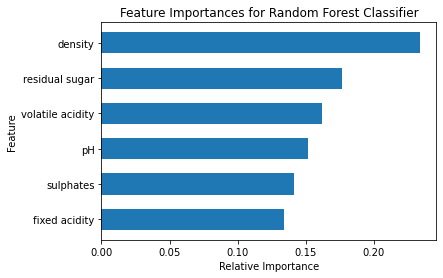

In [69]:
importances = rfc.feature_importances_
rfc_feature_names, rfc_feature_scores = zip(*sorted(zip(['fixed acidity', 'volatile acidity', 'residual sugar', 'density', 'pH', 'sulphates'],
importances), key=lambda x: x[1]))
y_position = list(range(len(rfc_feature_names)))
plt.barh(y_position, rfc_feature_scores, height=0.6, align='center')
plt.yticks(y_position , rfc_feature_names)
plt.xlabel('Relative Importance')
plt.ylabel('Feature')
t = plt.title('Feature Importances for Random Forest Classifier')

In [ ]:
rfc.plot_importance(xgb_clf, importance_type="weight")

In [70]:
#Adding constant column of ones, mandatory for sm.OLS model
#The performance metric used here to evaluate feature performance is pvalue. 
# If the pvalue is above 0.05 then we remove the feature, else we keep it.
X_1 = sm.add_constant(X)
#Fitting sm.OLS model
model = sm.OLS(y,X_1).fit()
model.pvalues

const               1.673776e-31
fixed acidity       1.633678e-06
volatile acidity    2.867433e-06
residual sugar      3.060706e-16
density             8.733747e-33
pH                  3.907254e-08
sulphates           4.640607e-03
dtype: float64

In [71]:
#Backward Elimination
cols = list(X.columns)
pmax = 1
while (len(cols)>0):
    p= []
    X_1 = X[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(y,X_1).fit()
    p = pd.Series(model.pvalues.values[1:],index = cols)      
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax>0.05):
        cols.remove(feature_with_p_max)
    else:
        break
selected_features_BE = cols
print(selected_features_BE)

['fixed acidity', 'volatile acidity', 'residual sugar', 'density', 'pH', 'sulphates']


In [72]:
# train the model
dtc = DecisionTreeClassifier(random_state=42)
dtc.fit(X_train, y_train)

# predict and evaluate performance
pred_dtc = dtc.predict(X_test)

In [73]:
pred_dtc = dtc.predict(X_test)
print(pred_dtc.shape)
print(y_test.shape)

(980,)
(980,)


In [74]:
print(classification_report(y_test, pred_dtc, target_names=["low","medium", "high"]))
print("Accuracy score:", accuracy_score(y_test, pred_dtc))
print("Confusion matrix:")
print(confusion_matrix(y_test, pred_dtc))

kappa = cohen_kappa_score(pred_dtc, y_test)
print("Cohen-Kappa score:", kappa)

              precision    recall  f1-score   support

         low       0.64      0.69      0.67       227
      medium       0.65      0.61      0.63       321
        high       0.62      0.62      0.62       432

    accuracy                           0.64       980
   macro avg       0.64      0.64      0.64       980
weighted avg       0.64      0.64      0.64       980

Accuracy score: 0.636734693877551
Confusion matrix:
[[157  11  59]
 [ 21 197 103]
 [ 66  96 270]]
Cohen-Kappa score: 0.43801908492857655


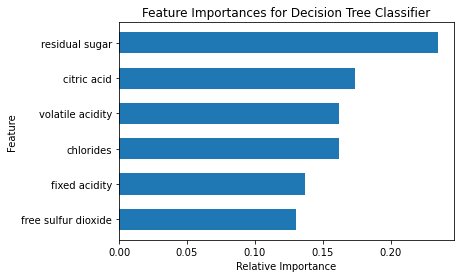

In [75]:
importances = dtc.feature_importances_
dtc_feature_names, dtc_feature_scores = zip(*sorted(zip(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
importances), key=lambda x: x[1]))
y_position = list(range(len(dtc_feature_names)))
plt.barh(y_position, dtc_feature_scores, height=0.6, align='center')
plt.yticks(y_position , dtc_feature_names)
plt.xlabel('Relative Importance')
plt.ylabel('Feature')
t = plt.title('Feature Importances for Decision Tree Classifier')

In [76]:

lr = LogisticRegression(max_iter = 1000)
lr.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

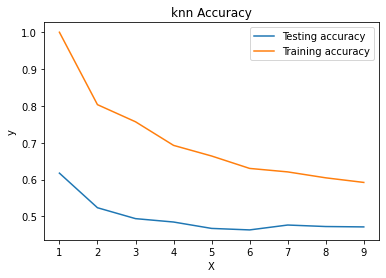

In [77]:
neighbors=np.arange(1,10)
train_accuracy=np.empty(len(neighbors))
test_accuracy=np.empty(len(neighbors))

for i, k in enumerate(neighbors):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    train_accuracy[i]=knn.score(X_train, y_train)
    test_accuracy[i]=knn.score(X_test, y_test)

plt.title("knn Accuracy")
plt.plot(neighbors, test_accuracy, label="Testing accuracy")
plt.plot(neighbors, train_accuracy, label="Training accuracy")
plt.legend()
plt.xlabel("X")
plt.ylabel("y")
plt.show()

In [78]:
knn=KNeighborsClassifier(n_neighbors=2)
knn.fit(X_train, y_train)
print(knn.score(X_test, y_test))

0.523469387755102


In [79]:
pred_knn = knn.predict(X_test)
print(pred_knn.shape)
print(y_test.shape)

(980,)
(980,)


In [80]:
print(classification_report(y_test, pred_knn, target_names=["low","medium", "high"]))
print("Accuracy score:", accuracy_score(y_test, pred_knn))
print("Confusion matrix:")
print(confusion_matrix(y_test, pred_knn))

kappa = cohen_kappa_score(pred_knn, y_test)
print("Cohen-Kappa score:", kappa)

              precision    recall  f1-score   support

         low       0.45      0.68      0.54       227
      medium       0.51      0.67      0.58       321
        high       0.65      0.34      0.44       432

    accuracy                           0.52       980
   macro avg       0.54      0.56      0.52       980
weighted avg       0.56      0.52      0.51       980

Accuracy score: 0.523469387755102
Confusion matrix:
[[154  31  42]
 [ 71 214  36]
 [114 173 145]]
Cohen-Kappa score: 0.2990705018738523


In [81]:
#If you are set on using KNN though, then the best way to estimate feature importance is by 
# taking the sample to predict on, and computing its distance from each of its nearest neighbors 
# for each feature (call these neighb_dist). Then do the same computations for a few random points 
# (call these rand_dist) instead of the nearest neighbors. Then for each feature, you take the ratio 
# of neighb_dist / rand_dist, and the smaller the ratio, the more important that feature is.


importances = knn.feature_importances_
knn_feature_names, knn_feature_scores = zip(*sorted(zip(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
importances), key=lambda x: x[1]))
y_position = list(range(len(knn_feature_names)))
plt.barh(y_position, knn_feature_scores, height=0.6, align='center')
plt.yticks(y_position , knn_feature_names)
plt.xlabel('Relative Importance')
plt.ylabel('Feature')
t = plt.title('Feature Importances for KNeighbors Classifier')

AttributeError: 'KNeighborsClassifier' object has no attribute 'feature_importances_'